In [1]:
from fastai.vision import *
import sys

import pose
from models import gccpm
%load_ext autoreload
%autoreload 2
root = Path('../../LIP').resolve()\

In [2]:
pose_label = pose.LIPLabel(root /'pose_annotations')
transforms = [pose.pose_flip_lr(p=0.5)], None
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=256, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (8/16) (256, 256),Pose (7/16) (256, 256),Pose (6/16) (256, 256),Pose (14/16) (256, 256),Pose (1/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: PoseLabelList
Pose (14/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256),Pose (16/16) (256, 256),Pose (10/16) (256, 256)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [3]:
model = gccpm.gccpm(Path('../../mobilenet_sgd_68.848.pth.tar').resolve())

[WARNING] Not found pre-trained parameters for model.0.1.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.1.1.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.1.4.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.2.1.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.2.4.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.3.1.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.3.4.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.4.1.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.4.4.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.5.1.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.5.4.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.6.1.num_batches_tracked
[WARNING] Not found pre-trained parameters for model.6.4.num_batches_tracked

In [7]:
def add_gaussian(keypoint_map, x, y, stride=8, sigma=7):
    n_sigma = 4
    tl = [int(x - n_sigma * sigma), int(y - n_sigma * sigma)]
    tl[0] = max(tl[0], 0)
    tl[1] = max(tl[1], 0)

    br = [int(x + n_sigma * sigma), int(y + n_sigma * sigma)]
    map_h, map_w = keypoint_map.shape
    br[0] = min(br[0], map_w * stride)
    br[1] = min(br[1], map_h * stride)

    shift = stride / 2 - 0.5
    for map_y in range(tl[1] // stride, br[1] // stride):
        for map_x in range(tl[0] // stride, br[0] // stride):
            d2 = (map_x * stride + shift - x) * (map_x * stride + shift - x) + \
                 (map_y * stride + shift - y) * (map_y * stride + shift - y)
            exponent = d2 / 2 / sigma / sigma
            if exponent > 4.6052:  # threshold, ln(100), ~0.01
                continue
            keypoint_map[map_y, map_x] += math.exp(-exponent)
            if keypoint_map[map_y, map_x] > 1:
                keypoint_map[map_y, map_x] = 1
                
def to_heatmaps(targets, size):
    heatmaps = targets.new_zeros(targets.shape[0], 17, 32, 32)
    gt = targets[..., :2].clamp(-1, 1)
    gt[torch.isnan(gt)] = 0.
    gt = pose.scale_targets(gt, size)
    for keypoint_maps, keypoints, visible in zip(heatmaps, gt, targets[..., 2]):
        for m, k, v in zip(keypoint_maps, keypoints, visible):
            if v == 0:
                continue
            add_gaussian(m, k[1], k[0])
        keypoint_maps[-1] = 1 - keypoint_maps.max(axis=0).values
    return heatmaps
    
def loss(outputs, targets):
    heatmaps = to_heatmaps(targets, outputs[-1].shape[-2:])
    loss = sum(F.mse_loss(o, heatmaps) for o in outputs)
    return loss

    
class GccpmPckh(pose.Pckh):
    def __init__(self, learn, pred_fn=None):
        super().__init__(learn, pred_fn)

    def on_batch_end(self, last_output, last_target, train, **kwargs):
        if not train:
            last_output = (None, last_output[-1][:, :-1])
            super().on_batch_end(last_output, last_target, train, **kwargs)

In [8]:
learner = Learner(data, model, loss_func=loss, callback_fns=GccpmPckh)

In [6]:
learner.lr_find()

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-04
Min loss divided by 10: 1.45E-02


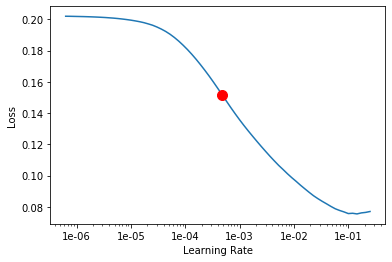

In [7]:
learner.recorder.plot(suggestion=True)

In [ ]:
lr = 1e-2
learner.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,0.001488,2615.233643,0.000464,0.027353,0.006032,0.000000,0.006537,0.001174,0.008540,0.008601,0.007351,1:21:34
1,0.001604,0.006073,0.000464,0.000052,0.000000,0.000166,0.000000,0.000000,0.000000,0.000174,0.000107,1:23:23
2,0.001777,40077.914062,0.005100,0.000104,0.000000,0.036394,0.000109,0.090423,0.011650,0.010017,0.018731,1:23:44
